## Imports

In [4]:
import requests
import os

from urllib.request import urlopen
from zipfile import ZipFile

from os import listdir
from os.path import isfile, join

import pandas as pd
import glob
import matplotlib.pyplot as plt

## Download and Unzip Data

In [2]:
def unzip(url, out_folder):
    try:
        tempzip = open("/tmp/tempfile.zip", "wb")
        tempzip.write(urlopen(url).read())
        tempzip.close()
        zf = ZipFile("/tmp/tempfile.zip")
        zf.extractall(path=out_folder)
        zf.close()
        print(f"Unzipped data to: {os.getcwd()}/{out_folder}")
    except Exception as req:
        raise UnzipFileError(req)

def get_data(url, out_folder):
    try:
        request = requests.get(url)
        if request.status_code == 200:
            if not os.path.exists(os.getcwd() + "/" + out_folder):
                os.makedirs(out_folder + "/")
        
    except Exception as req:
        print("Invalid URL provided.")
        print(req)

    return unzip(url, out_folder)

In [7]:
if not os.path.exists(os.getcwd() + "/data/raw/__MACOSX"):
    pass

else:
    files = glob.glob(os.getcwd() + "/data/raw/__MACOSX/*")
    for f in files:
        os.remove(f)
    os.rmdir(os.getcwd() + "/data/raw/__MACOSX")

if len(os.listdir(os.getcwd() + "/data/raw")) > 0:
    files = glob.glob(os.getcwd() + "/data/raw/*")
    for f in files:
        os.remove(f)
else:
    pass

In [8]:
time_get_data = %timeit -q -o -r 1 get_data(url="https://figshare.com/ndownloader/files/26766812", out_folder="data/raw")
print(f"Time Elapsed (to download and unzip the data): {time_get_data}")

Unzipped data to: /Users/jordancasoli/Documents/MDS/525/525-Group30/data/raw
Unzipped data to: /Users/jordancasoli/Documents/MDS/525/525-Group30/data/raw
Time Elapsed (to download and unzip the data): 2min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Combining all .csv files into one DataFrame

In [9]:
path, dirs, files = next(os.walk("data/raw"))
file_count = len(files)

def combine_data():
    combined_df = pd.DataFrame()
    for file in files:
        temp = pd.DataFrame()
        model_name = file.split('_')[0]
        temp = pd.read_csv('data/raw/' + file)
        temp['model'] = model_name
        combined_df = pd.concat([combined_df, temp], axis=0)
    return combined_df

time_combine_data = %timeit -q -o -r 1 combine_data()
print(f"Time Elapsed (to combine the data): {time_combine_data}\n")

combined_df = combine_data()

combined_df.info()

Time Elapsed (to combine the data): 2min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62513863 entries, 0 to 3541152
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.7+ GB


In [10]:
if len(os.listdir(os.getcwd() + "/data/processed")) > 0:
    files = glob.glob(os.getcwd() + "/data/processed/*")
    for f in files:
        os.remove(f)

In [12]:
%%time
combined_df.to_csv('data/processed/combined_df.csv')

CPU times: user 5min 53s, sys: 7.11 s, total: 6min
Wall time: 6min 8s


In [8]:
combined_df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


# Load the combined CSV to memory and perform a simple EDA

In [2]:
%load_ext memory_profiler

For our EDA, we will just be producing a simple histogram of rainfall amounts.

#### Loading the full dataset

/Users/jordancasoli/opt/miniconda3/envs/525_2022/lib/python3.8/multiprocessing/resource_tracker.py:96: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '


peak memory: 9562.81 MiB, increment: 8855.27 MiB
CPU times: user 48 s, sys: 18.3 s, total: 1min 6s
Wall time: 1min 33s


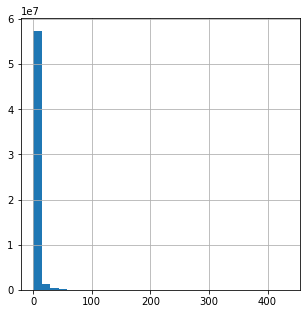

In [6]:
%%time
%%memit
df = pd.read_csv("data/processed/combined_df.csv", index_col=0)
df["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Jordan      |   macOS Big Sur  | 8GB |    M1     |   Y    |    1:33    |
| Vadim       |                  |     |           |        |            |
| Nick        |                  |     |           |        |            |

Observations: loading the whole dataset and performing our simple EDA requires 9562.81 MiB of memory, with a total wall time of 1 minue 33 seconds. 

#### Loading only the columns we need

peak memory: 8305.33 MiB, increment: 7776.27 MiB
CPU times: user 36.2 s, sys: 8.95 s, total: 45.2 s
Wall time: 55.1 s


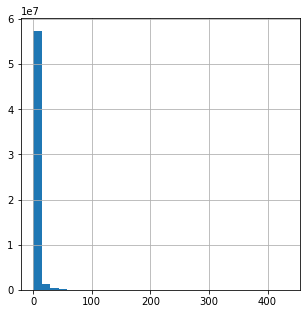

In [7]:
%%time
%%memit
useful_cols = ['time','rain (mm/day)']
df_columns = pd.read_csv("data/processed/combined_df.csv",usecols=useful_cols)
df_columns["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Jordan      |   macOS Big Sur  | 8GB |    M1     |   Y    |    55.1s   |
| Vadim       |                  |     |           |        |            |
| Nick        |                  |     |           |        |            |

Observations: loading only the columnns we needed reduced our peak memory requirement down to 8305.33 MiB of memory, with a total wall time of around 55 seconds (on My MAC). Surprisingly, this did not reduce the peak memory requirement that much! 

#### Changing the dtype 

The code below is adapted from lecture notes. 

In [11]:
print(f"Memory usage with float64: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 3000.67 MB
Memory usage with float32: 1750.39 MB


peak memory: 6359.86 MiB, increment: 5826.97 MiB
CPU times: user 1.69 s, sys: 3.39 s, total: 5.09 s
Wall time: 13.8 s


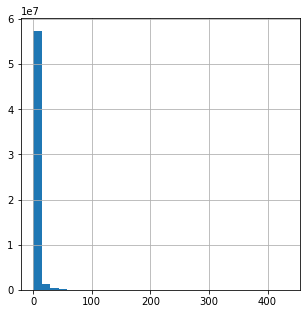

In [8]:
%%time
%%memit
df_dtype = df.astype({'lat_min': 'float32',
                      'lat_max': 'float32',
                      'lon_min': 'float32',
                      'lon_max': 'float32',
                      'rain (mm/day)': 'float32'})
df_dtype["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Jordan      |   macOS Big Sur  | 8GB |    M1     |   Y    |    13.8s   |
| Vadim       |                  |     |           |        |            |
| Nick        |                  |     |           |        |            |

Observations: Changing the dtype from float64 to float32 resulted in fairly significant decrease in peak memory usage as well as increase in speed. We needed reduced our peak memory requirement down to 6359.86 MiB, with a total wall time of around 14 seconds (on My MAC). If we wanted to further improve performance we could combine the last two strategies: only loading some columns combined with changing the dtype of those columns. 